# CICIDS - Hybrid Model CNN-GAN

The CICIDS2017 dataset is a comprehensive dataset for network intrusion detection, created by the Canadian Institute for Cybersecurity. It includes a diverse set of attack scenarios and normal traffic, making it suitable for training and evaluating intrusion detection systems.

The dataset includes various types of attacks such as Brute Force, Heartbleed, Botnet, DoS (Denial of Service), DDoS (Distributed Denial of Service), Web attacks, and Infiltration of the network from inside.

I aim to replicate this study: <https://www.jait.us/articles/2024/JAIT-V15N7-886.pdf>

In [1]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

## Step 1. EDA

In [2]:
%load_ext cudf.pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

In [3]:
# Should be 8 files
df_monday = pd.read_csv("./data/original/Monday-WorkingHours.pcap_ISCX.csv")
df_tuesday = pd.read_csv("./data/original/Tuesday-WorkingHours.pcap_ISCX.csv")
df_wednesday = pd.read_csv("./data/original/Wednesday-workingHours.pcap_ISCX.csv")

df_thursdayOne = pd.read_csv("./data/original/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv")
df_thursdayTwo = pd.read_csv("./data/original/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv")

df_fridayOne = pd.read_csv("./data/original/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")
df_fridayTwo = pd.read_csv("./data/original/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")
df_fridayThree = pd.read_csv("./data/original/Friday-WorkingHours-Morning.pcap_ISCX.csv")

# combine the 8 dataframes into 1
df_train = pd.concat([df_monday, df_tuesday, df_wednesday, df_thursdayOne, df_thursdayTwo, df_fridayOne, df_fridayTwo, df_fridayThree], ignore_index=True)


In [4]:
df_train.head(5)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,49188,4,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,49486,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [5]:
df_train.shape

(2830743, 79)

In [6]:
df_train.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                        Dtype
---  ------                        -----
 0    Destination Port             int64
 1    Flow Duration                int64
 2    Total Fwd Packets            int64
 3    Total Backward Packets       int64
 4   Total Length of Fwd Packets   int64
 5    Total Length of Bwd Packets  int64
 6    Fwd Packet Length Max        int64
 7    Fwd Packet Length Min        int64
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64
 11   Bwd Packet Length Min        int64
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max                 int64
 19   Fl

In [7]:
df_train.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,...,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06
mean,8.071483e+03,1.478566e+07,9.361160e+00,1.039377e+01,5.493024e+02,1.616264e+04,2.075999e+02,1.871366e+01,5.820194e+01,6.891013e+01,...,5.418218e+00,-2.741688e+03,8.155132e+04,4.113412e+04,1.531825e+05,5.829582e+04,8.316037e+06,5.038439e+05,8.695752e+06,7.920031e+06
std,1.828363e+04,3.365374e+07,7.496728e+02,9.973883e+02,9.993589e+03,2.263088e+06,7.171848e+02,6.033935e+01,1.860912e+02,2.811871e+02,...,6.364257e+02,1.084989e+06,6.485999e+05,3.933815e+05,1.025825e+06,5.770923e+05,2.363008e+07,4.602984e+06,2.436689e+07,2.336342e+07
min,0.000000e+00,-1.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-5.368707e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.300000e+01,1.550000e+02,2.000000e+00,1.000000e+00,1.200000e+01,0.000000e+00,6.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.000000e+01,3.131600e+04,2.000000e+00,2.000000e+00,6.200000e+01,1.230000e+02,3.700000e+01,2.000000e+00,3.400000e+01,0.000000e+00,...,1.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.430000e+02,3.204828e+06,5.000000e+00,4.000000e+00,1.870000e+02,4.820000e+02,8.100000e+01,3.600000e+01,5.000000e+01,2.616295e+01,...,2.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553500e+04,1.200000e+08,2.197590e+05,2.919220e+05,1.290000e+07,6.554530e+08,2.482000e+04,2.325000e+03,5.940857e+03,7.125597e+03,...,2.135570e+05,1.380000e+02,1.100000e+08,7.420000e+07,1.100000e+08,1.100000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


In [8]:
df_train.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

## Step 2. Data Cleaning

### A. Missing values

In [9]:
print(df_train.isna().sum().sum())

1358


In [10]:
df_train.dropna(subset=["Flow Bytes/s"], inplace=True)

In [11]:
print(df_train.isna().sum().sum())

0


### Inf. values

In [12]:
df_train = df_train.replace([np.inf, -np.inf], np.nan).dropna()

## Step 3. Data Preparation

### Experiment

In [13]:
# Remove all rows where " Label" is BENIGN

df_train = df_train[df_train[" Label"] != "BENIGN"]

### A. Categorical data

In [14]:
categorical_columns = df_train.select_dtypes(include=['object']).columns

for column in categorical_columns:
	print(f"Column '{column}' contains {len(df_train[column].value_counts())} unique values, namely {df_train[column].unique().tolist()}")

Column ' Label' contains 14 unique values, namely ['FTP-Patator', 'SSH-Patator', 'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye', 'Heartbleed', 'Infiltration', 'Web Attack � Brute Force', 'Web Attack � XSS', 'Web Attack � Sql Injection', 'DDoS', 'PortScan', 'Bot']


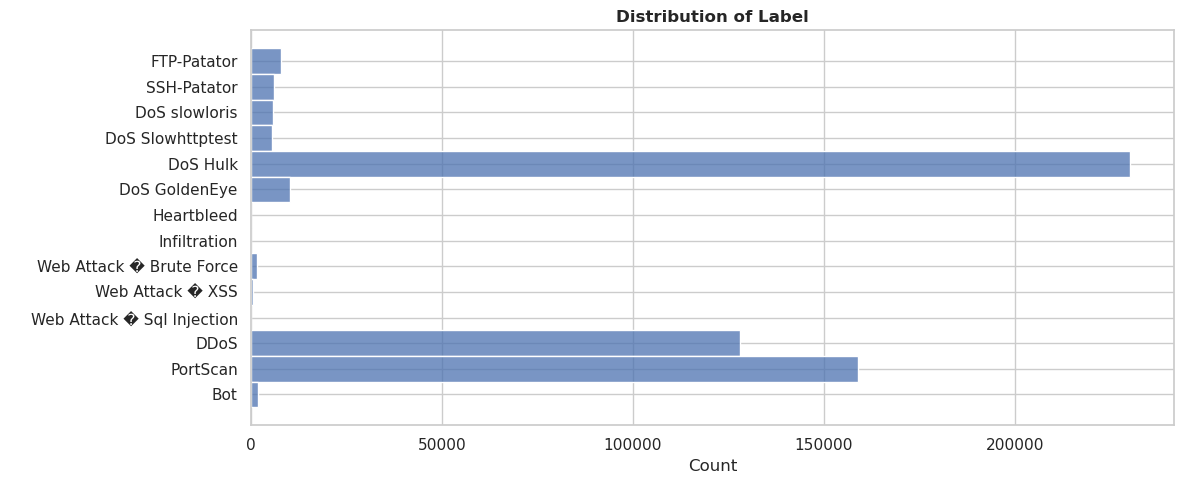

In [15]:
df = df_train

plt.figure(figsize=(12, 5))
sns.histplot(data=df, y=df[" Label"])
plt.ylabel(" ")
plt.title(f"Distribution of Label", fontweight="bold")

plt.tight_layout()
plt.show()

## Step 4. Preparing dataset for modeling

### A. Normalise numeric features

In [16]:
# Get all numerical columns
numerical_columns = df_train.select_dtypes(include="number").columns

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_train[numerical_columns] = scaler.fit_transform(df_train[numerical_columns])

### B. Map Labels to Multi-class

In [18]:
df_train[" Label"].value_counts()

 Label
DoS Hulk                      230124
PortScan                      158804
DDoS                          128025
DoS GoldenEye                  10293
FTP-Patator                     7935
SSH-Patator                     5897
DoS slowloris                   5796
DoS Slowhttptest                5499
Bot                             1956
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Infiltration                      36
Web Attack � Sql Injection        21
Heartbleed                        11
Name: count, dtype: int64

In [19]:
attack_mapping = {
	"DoS Hulk": 0,
	"PortScan": 1,
	"DDoS": 2,
	"DoS GoldenEye": 3,
	"FTP-Patator": 4,
	"SSH-Patator": 5,
	"DoS slowloris": 6,
	"DoS Slowhttptest": 7,
	"Bot": 8,
	"Web Attack � Brute Force": 9,
	"Web Attack � XSS": 10,
	"Infiltration": 11,
	"Web Attack � Sql Injection": 12,
	"Heartbleed": 13,
}

df_train[" Label"] = df_train[" Label"].map(attack_mapping)

In [20]:
df_train[" Label"].value_counts()

 Label
0     230124
1     158804
2     128025
3      10293
4       7935
5       5897
6       5796
7       5499
8       1956
9       1507
10       652
11        36
12        21
13        11
Name: count, dtype: int64

### C. Data Splitting

In [21]:
X = df_train.drop(columns=" Label")
y = df_train[" Label"]

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### D. Apply SMOTE to balance the training data

In [23]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# 1. Undersample the majority class
undersampling_strategy = {
    0: 1000,
    1: 1000,
    2: 1000,
    3: 1000,
    4: 1000,
    5: 1000,
    6: 1000,
    7: 1000,
    8: 1000,
    9: 1000,
}
rus = RandomUnderSampler(random_state=42, sampling_strategy=undersampling_strategy)
X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train, y_train)

# 2. Oversample the minority class
smote = SMOTE(random_state=42, sampling_strategy="auto")
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_undersampled, y_train_undersampled)

In [24]:
# Check class distribution after SMOTE
from collections import Counter

print(f"Class distribution before SMOTE: {Counter(y_train)}")
print(f"Class distribution after SMOTE: {Counter(y_train_balanced)}")

Class distribution before SMOTE: Counter({0: 183868, 1: 127224, 2: 102409, 3: 8230, 4: 6395, 5: 4693, 6: 4692, 7: 4410, 8: 1555, 9: 1200, 10: 513, 11: 28, 12: 18, 13: 9})
Class distribution after SMOTE: Counter({0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000, 10: 1000, 11: 1000, 12: 1000, 13: 1000})


### E. PyTorch Model Design

#### 1. CNN Feature Extractor

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset

# Define CNN Feature Extractor
class CNNFeatureExtractor(nn.Module):
    def __init__(self, input_size, num_filters=32):
        super(CNNFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear((input_size // 2) * num_filters, 64)
    
    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        return self.fc(x)

#### 2. Generator-Discriminator

In [26]:
# Define Generator
class Generator(nn.Module):
    def __init__(self, noise_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.model(x)


# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

#### 3. Define Hybrid Model

In [27]:
# Define Hybrid Model
class HybridCNNGAN(nn.Module):
    def __init__(self, input_size, output_size, noise_dim=32):
        super(HybridCNNGAN, self).__init__()
        self.feature_extractor = CNNFeatureExtractor(input_size)
        self.classifier = nn.Linear(64, output_size)
        self.generator = Generator(noise_dim, input_size)
        self.discriminator = Discriminator(input_size)
    
    def forward(self, x):
        features = self.feature_extractor(x)
        return self.classifier(features)

In [28]:
# Initialize model
input_size = X_train_balanced.shape[1]
output_size = len(attack_mapping)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridCNNGAN(input_size, output_size).to(device)

### F. Training the Model

In [29]:
# Training Setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_dataset = TensorDataset(torch.tensor(X_train_balanced.values, dtype=torch.float32).to(device),
                              torch.tensor(y_train_balanced.values, dtype=torch.long).to(device))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training Loop
epoch = 0
current_highest_accuracy = 0.0

while True:
    epoch += 1
    model.train()
    total_loss, correct, total = 0, 0, 0
    
    for i, (data, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = correct / total
        
    if epoch % 10 == 0:
        if epoch_accuracy > current_highest_accuracy:
            current_highest_accuracy = epoch_accuracy
            print(f'[Epoch {epoch:<4}] - Loss: {epoch_loss:.4f} - Accuracy: {epoch_accuracy:.4f} - NEW BEST')
        else:
            print(f'[Epoch {epoch:<4}] - Loss: {epoch_loss:.4f} - Accuracy: {epoch_accuracy:.4f}')
    
    if epoch_accuracy >= 0.9750:
        print(f"Training stopped: Accuracy reached {epoch_accuracy:.4f} at epoch {epoch}.")
        break

[Epoch 10  ] - Loss: 0.3131 - Accuracy: 0.8606 - NEW BEST
[Epoch 20  ] - Loss: 0.2459 - Accuracy: 0.8788 - NEW BEST
[Epoch 30  ] - Loss: 0.2123 - Accuracy: 0.8902 - NEW BEST
[Epoch 40  ] - Loss: 0.1996 - Accuracy: 0.8960 - NEW BEST
[Epoch 50  ] - Loss: 0.1940 - Accuracy: 0.8989 - NEW BEST
[Epoch 60  ] - Loss: 0.1912 - Accuracy: 0.8997 - NEW BEST
[Epoch 70  ] - Loss: 0.1866 - Accuracy: 0.8996
[Epoch 80  ] - Loss: 0.1802 - Accuracy: 0.9036 - NEW BEST
[Epoch 90  ] - Loss: 0.1792 - Accuracy: 0.9031
[Epoch 100 ] - Loss: 0.1782 - Accuracy: 0.9020
[Epoch 110 ] - Loss: 0.1736 - Accuracy: 0.9054 - NEW BEST
[Epoch 120 ] - Loss: 0.1743 - Accuracy: 0.9052
[Epoch 130 ] - Loss: 0.1721 - Accuracy: 0.9038
[Epoch 140 ] - Loss: 0.1722 - Accuracy: 0.9037
[Epoch 150 ] - Loss: 0.1706 - Accuracy: 0.9049
[Epoch 160 ] - Loss: 0.1681 - Accuracy: 0.9082 - NEW BEST
[Epoch 170 ] - Loss: 0.1682 - Accuracy: 0.9073
[Epoch 180 ] - Loss: 0.1658 - Accuracy: 0.9092 - NEW BEST
[Epoch 190 ] - Loss: 0.1683 - Accuracy: 0.90

KeyboardInterrupt: 

In [30]:
torch.save(model.state_dict(), './models/hybrid_cnn_gan_FULL_better-sampling_without-benign_run-until-high-accuracy.pth')

### G. Evaluating both Models

In [31]:
model = HybridCNNGAN(input_size, output_size).to(device)
model.load_state_dict(torch.load('./models/hybrid_cnn_gan_FULL_better-sampling_without-benign_run-until-high-accuracy.pth'))
model.eval()

HybridCNNGAN(
  (feature_extractor): CNNFeatureExtractor(
    (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
    (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc): Linear(in_features=1248, out_features=64, bias=True)
  )
  (classifier): Linear(in_features=64, out_features=14, bias=True)
  (generator): Generator(
    (model): Sequential(
      (0): Linear(in_features=32, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=78, bias=True)
      (3): Tanh()
    )
  )
  (discriminator): Discriminator(
    (model): Sequential(
      (0): Linear(in_features=78, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=1, bias=True)
      (3): Sigmoid()
    )
  )
)

In [32]:
# Evaluation
from sklearn.metrics import accuracy_score, f1_score, classification_report

device = torch.device("cpu")
model.to(device)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)


def evaluate_model(model, X, y):
    with torch.no_grad():
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
    acc = accuracy_score(y.cpu().numpy(), predicted.cpu().numpy())
    f1 = f1_score(y.cpu().numpy(), predicted.cpu().numpy(), average='weighted')
    report = classification_report(y.cpu().numpy(), predicted.cpu().numpy(), target_names=attack_mapping)
    return acc, f1, report

model_acc, model_f1, model_report = evaluate_model(model, X_test_tensor, y_test_tensor)

print(f"Accuracy: {model_acc:.4f}, F1 Score: {model_f1:.4f}\n{model_report}")

Accuracy: 0.9960, F1 Score: 0.9962
                            precision    recall  f1-score   support

                  DoS Hulk       1.00      1.00      1.00     46256
                  PortScan       1.00      1.00      1.00     31580
                      DDoS       1.00      1.00      1.00     25616
             DoS GoldenEye       0.97      1.00      0.98      2063
               FTP-Patator       0.99      1.00      0.99      1540
               SSH-Patator       0.99      1.00      0.99      1204
             DoS slowloris       0.92      0.99      0.96      1104
          DoS Slowhttptest       0.99      0.98      0.99      1089
                       Bot       1.00      1.00      1.00       401
  Web Attack � Brute Force       0.82      0.57      0.67       307
          Web Attack � XSS       0.43      0.73      0.54       139
              Infiltration       0.89      1.00      0.94         8
Web Attack � Sql Injection       0.06      0.67      0.11         3
            